VERSIONE DEFINITIVA

# TESI: Confronto tra diverse metodologie statistiche per la quantificazione dei volumi derivabili da un corso d'acqua

## 1) INTRODUZIONE

In idrologia, la stima del volume derivabile da una certa sezione di un corso d'acqua non è banale, poiché non è nota a priori la disponibilità idrica futura. Per ovviare a questa incertezza intrinseca del problema, esistono alcuni approcci di tipo statistico-probabilistico che conducono alla stima del volume derivabile, sulla base delle misurazioni di portata degli anni precedenti.

In questo studio vengono messi al vaglio i due principali metodi:
1) APPROCCIO MULTI-ANNO: si esegue uno studio annuale, cioè si calcola il volume derivabile mensile per ogni anno a partire dalle portate. Dopodiché, si confrontano i valori e si calcolano alcuni indicatori statistici (media, varianza).
2) APPROCCIO SULL'ANNO TIPO: si esegue uno studio su due anni di riferimento, "anno medio" e "anno scarso". Il primo è costituito da 365 misurazioni di portata, ognuna pari alla media delle portate giornaliere degli anni in esame; più precisamente vengono riordinati i dataset annuali in ordine crescente e vengono mediate le portate (e.g. la portata più piccola dell'anno medio sarà la media delle portate più piccole di ogni anno $\dots$). Il secondo invece si ottiene con la stessa logica, tuttavia al posto della media viene considerato il quantile 0.2 . Ottenuti gli anni di riferimento, si eseguono anche qui le analisi statistiche del caso.

Infine, si fa un confronto tra le due metodologie mettendo in luce le differenze.

Questo applicativo si propone di ricevere in input le serie storiche delle portate giornaliere di alcune stazioni di misura (a cura di $\href{https://www.arpa.piemonte.it/rischi_naturali/snippets_arpa_graphs/map_meteoweb/?rete=stazione_meteorologica}{ARPA\,Piemonte}$) ed eseguire tutti i passaggi necessari per ottenere un'analisi statistica sui volumi derivabili.

### Stazioni in esame

Le stazioni prese in esame per l'analisi in questione sono le seguenti, tuttavia il codice funzionerebbe in modo del tutto analogo al variare di esse.
- Stazione ALBA TANARO
- Stazione ANDONNO GESSO
- Stazione CARIGNANO PO
- Stazione SAN SEBASTIANO PO
- Stazioene VEROLENGO DORA BALTEA

I criteri alla base della selezioni sono i seguenti
- Si prediligono stazioni con uno storico significativo di dati 
- Si prediligono stazioni dotate di misurazioni recenti

In [44]:
#Pacchetti utili
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Dataframe in esame
df_carignano = pd.read_csv(r"C:\Users\MATTEO IENTILE\Desktop\TESI\Codice sorgente tesi\CARIGNANO PO.csv") 
df_po = pd.read_csv(r"C:\Users\MATTEO IENTILE\Desktop\TESI\Codice sorgente tesi\SAN SEBASTIANO PO.csv") 
df_gesso = pd.read_csv(r"C:\Users\MATTEO IENTILE\Desktop\TESI\Codice sorgente tesi\ANDONNO GESSO.csv") 
df_tanaro = pd.read_csv(r"C:\Users\MATTEO IENTILE\Desktop\TESI\Codice sorgente tesi\ALBA TANARO.csv") 
df_dora = pd.read_csv(r"C:\Users\MATTEO IENTILE\Desktop\TESI\Codice sorgente tesi\VEROLENGO DORA BALTEA.csv") 

dataframes = [df_carignano, df_po, df_gesso, df_tanaro, df_dora]

## 2) Data collection and data exploration

Per prima cosa, si rende necessario visualizzare i dati a disposizione e verificare l'eventuale necessità di gestire casi particolari. Un tipico esempio potrebbe essere l'assenza di misurazioni per un certo periodo di tempo (e.g. guasto di un sensore).

In [46]:
#VISUALIZZAZIONE df IN ESAME
dataframes

[            DATA  Livello idrometrico fiume (m)  Portata fiume (m³/s)
 0     2007-01-01                           0.93                 27.50
 1     2007-01-02                           0.91                 26.20
 2     2007-01-03                           0.93                 27.70
 3     2007-01-04                           0.95                 29.90
 4     2007-01-05                           0.95                 29.90
 ...          ...                            ...                   ...
 6204  2023-12-27                           1.00                 23.79
 6205  2023-12-28                           0.99                 22.73
 6206  2023-12-29                           0.99                 22.82
 6207  2023-12-30                           0.98                 22.62
 6208  2023-12-31                           0.99                 23.18
 
 [6209 rows x 3 columns],
             DATA  Livello idrometrico fiume (m)  Portata fiume (m³/s)
 0     2007-02-28                           1.18 

Si osserva che per il secondo dataset della lista (df_po) le misurazioni partono dal 28 di febbraio del 2007. In questi casi l'opzione migliore è scartare l'intero anno. 

In [47]:
#VERIFICA DELLA PRESENZA DI DATI MANCANTI
for df in dataframes:
    print(df.isna().sum())

DATA                              0
Livello idrometrico fiume (m)    99
Portata fiume (m³/s)              0
dtype: int64
DATA                             0
Livello idrometrico fiume (m)    4
Portata fiume (m³/s)             0
dtype: int64
DATA                             0
Livello idrometrico fiume (m)    0
Portata fiume (m³/s)             0
dtype: int64
DATA                              0
Livello idrometrico fiume (m)    82
Portata fiume (m³/s)              0
dtype: int64
DATA                               0
Livello idrometrico fiume (m)    118
Portata fiume (m³/s)               0
dtype: int64


Non sono presenti dati mancanti in merito ai valori di portata

In [48]:
#VISUALIZZAZIONE DEL TIPO DI DATO
for df in dataframes:
    print(df.dtypes)

DATA                              object
Livello idrometrico fiume (m)    float64
Portata fiume (m³/s)             float64
dtype: object
DATA                              object
Livello idrometrico fiume (m)    float64
Portata fiume (m³/s)             float64
dtype: object
DATA                              object
Livello idrometrico fiume (m)    float64
Portata fiume (m³/s)             float64
dtype: object
DATA                              object
Livello idrometrico fiume (m)    float64
Portata fiume (m³/s)             float64
dtype: object
DATA                              object
Livello idrometrico fiume (m)    float64
Portata fiume (m³/s)             float64
dtype: object


Si noti che la colonna ["DATA"] è riconosciuta come object, ma per le analisi che seguiranno sarà utile farla intendere al programma come una data vera e propria, costituita da giorno, mese e anno.

Inoltre, in idrologia è buona norma eliminare il 29 febbraio negli anni bisestili.

## 3) Data cleaning and data manipulation

Si procede alle operazioni individuate nello step precedente.

In [49]:
#1) RIMOZIONE DELLA COLONNA "Livello idrometrico fiume (m)", 2) CONVERSIONE DELLA COLONNA "DATA" IN dtype=datetime, 3) RIMOZIONE 29 FEBBRAIO
for df in dataframes:
    df.drop("Livello idrometrico fiume (m)", axis=1, inplace=True) #1)
    df["DATA"] =  pd.to_datetime(df["DATA"], format="%Y-%m-%d") #2)
    df.drop(df[(df["DATA"].dt.month == 2) & (df["DATA"].dt.day == 29)].index, inplace=True) #3)

#RIMOZIONE DELL'ANNO 2007 DAL df_po
df_po = df_po[~((df_po["DATA"].dt.year == 2007))]

Per le analisi che seguono risulta utile, dato un dataframe, suddividerlo in "sotto-dataframe" annuali. 

Per far questo, il modo migliore è creare una funzione che, ricevuto in input un df sia in grado di eseguire questa operazione. Inoltre, nella stessa funzione è utile già implementare qualche altra operazione:
- riordinare i df annuali per portate crescenti
- creare le colonne $d$ e $F sup$, rispettivamente la durata e la frequenza di superamento (ottenuta con la plotting position di Weibull). 

In [50]:
#FUNZIONE CHE SUDDIVIDE df ANNO PER ANNO E CALCOLA Fsup
def edit_dataframe(df):
    years_analysis = {}
    first_year = df["DATA"].iloc[0].year
    last_year = df["DATA"].iloc[-1].year
    for year in np.arange(first_year, last_year + 1, 1):
        df_annual = df[df["DATA"].dt.year == year]
        years_analysis[year] = df_annual
        
    for year, df in years_analysis.items():
        df = df.sort_values("Portata fiume (m³/s)")
        df["d"] = np.arange(365, 0, -1)
        df["F sup"] = df["d"] / 366
        years_analysis[year] = df
    return years_analysis

#INSERIMENTO DEI df IN UNA LISTA: il primo elemento fornisce il df_carignano diviso per anno, il secondo il df_po etc.
dataframes = [df_carignano, df_po, df_gesso, df_tanaro, df_dora]
edited_dfs = [edit_dataframe(df) for df in dataframes]

Per accedere alla lista si utilizzi questa nomenclatura: 

$edited\_ dfs[elemento\,\,lista][anno\,\,di\,\,interesse]$

Per esempio, il comando edited_dfs[0][2007] stamperà, sottoforma di dataset, l'anno 2007 del df_carignano ordinato per valori di portata crescente e con $d$ e $F\,sup$

In [51]:
edited_dfs[0][2007]

,DATA,Portata fiume (m³/s),d,F sup
254,2007-09-12,8.2,365,0.997268
205,2007-07-25,10.5,364,0.994536
210,2007-07-30,11.0,363,0.991803
209,2007-07-29,11.5,362,0.989071
207,2007-07-27,11.7,361,0.986339
...,...,...,...,...
160,2007-06-10,135.0,5,0.013661
124,2007-05-05,158.0,4,0.010929
159,2007-06-09,160.0,3,0.008197
157,2007-06-07,179.0,2,0.005464


### 3.1) Determinazione del deflusso ecologico

A seguito del $\href{http://arianna.cr.piemonte.it/regolafo/dettaglioRegolamento.do?urnRegolamento=urn:nir:regione.piemonte:regolamento:2021-12-27;14}{Regolamento\,\,Regionale}$ vigente dal 28/12/2021, il prelievo dai corsi d'acqua deve tener conto di una certa portata minima da rilasciare in alveo: il Deflusso ecologico $DE = k \cdot q_{meda} \cdot S\cdot M \cdot A \cdot Z \cdot T = DMV_{base}\cdot Z \cdot T$. 

Per il calcolo dei coefficienti presenti nella formula si fa riferimento agli Allegati del Regolamento sopra citato. Ai fini di una maggior precisione nella determinazione dei parametri si fa uso del $\href{https://geoportale.arpa.piemonte.it/app/public/?pg=mappa&ids=cc7a350009fe49d0bb97e517bb3299d6}{Geoportale}$ di ARPA Piemonte. Inoltre, può essere per le definizioni "Alto Po" e "Basso Po" il $\href{https://www.regione.piemonte.it/web/temi/ambiente-territorio/ambiente/acqua/piano-tutela-delle-acque-aggiornamento-2021}{PTA\,\,2021}$

Codici (da Geoportale): 
- Alba Tanaro: 05SS4N803PI
- Andonno Gesso: 04SS3N225PI
- Carignano Po: 06SS4D382PI
- San Sebastiano Po: 06SS4D384PI
- Verolengo Dora: 06GH4F168PI

In [52]:
# 1) FATTORE "k" (da ALLEGATO B) 
k_albatanaro = 0.10 
k_andonnogesso = 0.15
k_carignanopo = 0.10 # "basso Po" dal PTA 2007, pagina 119/320 e TAV A2.12 
k_sansebpo = 0.10 # "basso Po" dal PTA 2007, pagina 119/320 e TAV A2.12
k_verolengodorab = 0.13

In [53]:
# 2) ESTENSIONE BACINO "S" (da INDICAZIONE ALLEGATO B -> https://www.regione.piemonte.it/web/sites/default/files/media/documenti/2019-01/pta2018_allegato_3a_bilancio_idrico_regionale_delle_acque_superficiali.pdf)
S_albatanaro = 3579 #km^2
S_andonnogesso = 354 #km^2
S_carignanopo = 3878 #km^2
S_sansebpo = 9188 #km^2
S_verolengodorab = 3942 #km^2

In [54]:
# 3) FATTORE "Z" (da ALLEGATO C matchando il codice identificativo, Z=1 in assenza di matching)
Z_albatanaro = 1
Z_andonnogesso = 1.5
Z_carignanopo = 1
Z_sansebpo = 1 
Z_verolengodorab = 1.5 

In [55]:
# 4) FATTORE "M" (da PTA2007_tav2.12 + Geoportale, visualizzazione bacini secondari)
M_albatanaro = 1.10 #(classe 3)
M_andonnogesso = 0.9 #(classe 1)
M_carignanopo = 1.10 #(classe 3)
M_sansebpo = 1.10 #(classe 3)
M_verolengodorab = 1.10 # (classe 3)

In [56]:
# 5) FATTORE "A" (da TAV 2.12)
A_albatanaro = 1 # il tratto non va corretto. 
A_andonnogesso = 1 # il tratto in esame non va corretto, secondo la TAV 2.12
A_carignanopo = 1 #Al02, classe 3
A_sansebpo = 1 # ALl02, classe 3
A_verolengodorab = 1 # Al15, classe 2

In [57]:
# 6) FATTORE "T" (da ALLEGATO C): si realizzano dei dataframe fatti in questo modo: T|mese

mesi = ['gennaio', 'febbraio', 'marzo', 'aprile', 'maggio', 'giugno','luglio', 'agosto', 'settembre','ottobre', 'novembre', 'dicembre']

T_albatanaro = [1, 1, 1, 2, 2, 2, 0.7, 0.7, 0.7, 0.7, 0.7, 1] #gruppo C
T_albatanarodf = pd.DataFrame(T_albatanaro, columns=['T']) 
T_albatanarodf["mese"] = mesi

T_andonnogesso = [1, 1, 1, 2, 2, 2, 0.7, 0.7, 0.7, 0.7, 0.7, 1] #gruppo C
T_andonnogessodf = pd.DataFrame(T_albatanaro, columns=['T'])
T_andonnogessodf["mese"] = mesi

T_carignanopo = [1, 1, 1, 1.8, 1.8, 1.8, 0.7, 0.7, 0.7, 0.7, 1, 1] #gruppo F
T_carignanopodf = pd.DataFrame(T_albatanaro, columns=['T'])
T_carignanopodf["mese"] = mesi

T_sansebpo =  [1, 1, 1, 1.8, 1.8, 1.8, 0.7, 0.7, 0.7, 0.7, 1, 1] #gruppo F
T_sansebpodf = pd.DataFrame(T_albatanaro, columns=['T'])
T_sansebpodf["mese"] = mesi

T_verolengodorab = [0.7, 0.7, 1, 1, 1.8, 1.8, 1, 1, 1, 1, 1, 0.7]  #gruppo D
T_verolengodorabdf = pd.DataFrame(T_albatanaro, columns=['T'])
T_verolengodorabdf["mese"] = mesi 

In [58]:
#ESEMPIO DEL df CREATO
#T_sansebpodf

In [59]:
# 7) FATTORE q_meda=Q_media/S (da ALLEGATO C)

Qm_albatanaro = np.mean(df_tanaro["Portata fiume (m³/s)"])
Qm_andonnogesso = np.mean(df_gesso["Portata fiume (m³/s)"])
Qm_carignanopo = np.mean(df_carignano["Portata fiume (m³/s)"])
Qm_sansebpo = np.mean(df_po["Portata fiume (m³/s)"])
Qm_verolengodorab = np.mean(df_dora["Portata fiume (m³/s)"])

qm_albatanaro = (Qm_albatanaro*1000) / S_albatanaro #l/(s*km^2)
qm_andonnogesso = (Qm_andonnogesso*1000) /  S_andonnogesso
qm_carignanopo = (Qm_carignanopo *1000) / S_carignanopo
qm_sansebpo = (Qm_sansebpo *1000) / S_sansebpo
qm_verolengodorab = (Qm_verolengodorab*1000) / S_verolengodorab

In [60]:
#DETERMINAZIONE DE: si calcolano i valori di deflusso ecologico per ogni mese e si mettono all'interno di una lista "DE_nomestazione". L'elemento 0 sarà il DE di gennaio, e così via.

DE_albatanaro = []
for T in T_albatanarodf["T"]:
    DE = k_albatanaro*qm_albatanaro*S_albatanaro*A_albatanaro*M_albatanaro*Z_albatanaro*T
    DE_albatanaro.append(DE/1000)
T_albatanarodf["DE (mc/s)"] = DE_albatanaro

DE_andonnogesso = []
for T in T_andonnogessodf["T"]:
    DE = k_albatanaro*qm_albatanaro*S_albatanaro*A_albatanaro*M_albatanaro*Z_albatanaro*T
    DE_andonnogesso.append(DE/1000)
T_andonnogessodf["DE (mc/s)"] = DE_andonnogesso

DE_carignanopo = []
for T in T_carignanopodf["T"]:
    DE = k_albatanaro*qm_albatanaro*S_albatanaro*A_albatanaro*M_albatanaro*Z_albatanaro*T
    DE_carignanopo.append(DE/1000)
T_carignanopodf["DE (mc/s)"] = DE_carignanopo

DE_sansebpo = []
for T in T_sansebpodf["T"]:
    DE = k_albatanaro*qm_albatanaro*S_albatanaro*A_albatanaro*M_albatanaro*Z_albatanaro*T
    DE_sansebpo.append(DE/1000)
T_sansebpodf["DE (mc/s)"] = DE_sansebpo

DE_verolengodorab = []
for T in T_verolengodorabdf["T"]:
    DE = k_albatanaro*qm_albatanaro*S_albatanaro*A_albatanaro*M_albatanaro*Z_albatanaro*T
    DE_verolengodorab.append(DE/1000)
T_verolengodorabdf["DE (mc/s)"] = DE_verolengodorab

In [61]:
#ESEMPIO DI COSA SI È OTTENUTO:
T_sansebpodf

,T,mese,DE (mc/s)
0,1.0,gennaio,7.126030
1,1.0,febbraio,7.126030
2,1.0,marzo,7.126030
3,2.0,aprile,14.252059
4,2.0,maggio,14.252059
5,2.0,giugno,14.252059
6,0.7,luglio,4.988221
7,0.7,agosto,4.988221
8,0.7,settembre,4.988221
9,0.7,ottobre,4.988221


### 3.2) Calcolo della portata depurata del Deflusso Ecologico e Volume giornaliero derivabile

Per la determinazione del volume derivabile si deve depurare la portata del fiume del valore di DE, tenendo sempre conto che l'ipotetica opera di presa può derivare al più la portata media di lungo periodo. Pertanto, si procede con la definizione di una funzione che riceva un dataframe in input e che detrmini la portata derivabile $Q_{derivabile}$ ed il conseguente volume giornaliero.

La logica scelta per questo step è la seguente: si creano dei dizionari in modo che, digitato il nome del dataframe, vengano automaticamente messi nei calcoli il deflusso ecologico e la portata media associata. Per accedere applicare la funzione si utilizzi la nomenclatura: $daily\_withdrawal(df,\,\,"df")$

In [62]:
#FUNZIONE CHE CALCOLA IL VOLUME DERIVABILE GIORNALIERO, DATO IN INPUT UN df
def daily_withdrawal(df, df_name):
    analysis_range = [] #lista vuota dentro cui vanno messi gli anni di analisi (2007...2023)
    first_year = df["DATA"].iloc[0].year
    last_year = df["DATA"].iloc[-1].year
    for i in range(first_year, last_year + 1, 1):
        analysis_range.append(i)
    
    DE_dictionary = {              #Dizionario che, digitata la chiave (nome del df), restituisce il corrispondente DE di ogni mese
        "df_tanaro": DE_albatanaro,
        "df_gesso": DE_andonnogesso,
        "df_carignano": DE_carignanopo,
        "df_po": DE_sansebpo,
        "df_dora": DE_verolengodorab
    }
    
    Qm_dictionary = {             # Dizionario che, digitata la chiave (nome del df), restituisce la corrispondente Qmedia
        "df_tanaro": Qm_albatanaro,
        "df_gesso": Qm_andonnogesso,
        "df_carignano": Qm_carignanopo,
        "df_po": Qm_sansebpo,
        "df_dora": Qm_verolengodorab
    }

    DE = DE_dictionary.get(df_name) # Comando che esegue l'operazione "ricevo key (nome df) -> accedo al df corretto -> prendo il corrispondente DE"
    Qm = Qm_dictionary.get(df_name) # Comando che esegue l'operazione "ricevo key (nome df) -> accedo al df corretto -> prendo il corrispondente Qm"
    
    Deflusso_ecologico = []
    
    for data in df["DATA"]:
        Deflusso_ecologico.append(DE[data.month - 1]) # Comando che estrae l'elemento della lista DE corretto a seconda del mese. Il -1 c'è perché il conto va ritarato all'indice della lista che inizia da 0 
    
    df["DE"] = Deflusso_ecologico
    df["Q-DE"] = df["Portata fiume (m³/s)"] - df["DE"]
    df["Q-DE"] = df["Q-DE"].clip(lower=0)
    df["Q media"] = Qm
    df["Q derivata"] = np.minimum(df["Q-DE"], df["Q media"])
    df["Volume giornaliero derivato (mc)"] = df["Q derivata"]*86400 #Volume giornaliero = Portata [mc/s] * secondi in un giorno. 
    
    return df


In [63]:
daily_withdrawal(df_po, "df_po")

C:\Users\MATTEO IENTILE\AppData\Local\Temp\ipykernel_36416\3783679178.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DE"] = Deflusso_ecologico
C:\Users\MATTEO IENTILE\AppData\Local\Temp\ipykernel_36416\3783679178.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Q-DE"] = df["Portata fiume (m³/s)"] - df["DE"]
C:\Users\MATTEO IENTILE\AppData\Local\Temp\ipykernel_36416\3783679178.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,DATA,Portata fiume (m³/s),DE,Q-DE,Q media,Q derivata,Volume giornaliero derivato (mc)
307,2008-01-01,17.90,7.12603,10.77397,125.234382,10.77397,9.308710e+05
308,2008-01-02,18.50,7.12603,11.37397,125.234382,11.37397,9.827110e+05
309,2008-01-03,18.90,7.12603,11.77397,125.234382,11.77397,1.017271e+06
310,2008-01-04,22.60,7.12603,15.47397,125.234382,15.47397,1.336951e+06
311,2008-01-05,25.30,7.12603,18.17397,125.234382,18.17397,1.570231e+06
...,...,...,...,...,...,...,...
6146,2023-12-27,32.35,7.12603,25.22397,125.234382,25.22397,2.179351e+06
6147,2023-12-28,31.86,7.12603,24.73397,125.234382,24.73397,2.137015e+06
6148,2023-12-29,24.77,7.12603,17.64397,125.234382,17.64397,1.524439e+06
6149,2023-12-30,26.04,7.12603,18.91397,125.234382,18.91397,1.634167e+06


## 4) Analisi dei volumi derivabili

### 4.A) APPROCCIO MULTI-ANNO 

Per l'approccio multi-anno si rende necessario deterinare il volume derivabile di mese in mese. Avendo definito la funzione che calcola il volume giornaliero, può essere utile sfruttala inserendo all'interno di un'altra funzione che calcoli stavolta i volumi mensili.

In [64]:
#FUNZIONE CHE RESTITUISCE I VOLUMI MENSILI DERIVABILI, DATO UN df IN INPUT
def monthly_withdrawal(df, df_name):
    df = daily_withdrawal(df, df_name) # si richiama la funzione per il calcolo del volume giornaliero
    df["Year"] = df["DATA"].dt.year #si crea la colonna "anno"
    df["Month"] = df["DATA"].dt.month #si crea la colonna "mese"
    monthly_volume = df.groupby(["Year", "Month"])["Volume giornaliero derivato (mc)"].sum().reset_index() #si prendono i volumi giornalieri di un mese di un certo anno e si sommano
    monthly_volume.rename(columns={"Volume giornaliero derivato (mc)" : "Volume mensile (mc)"}, inplace=True)
    
    return monthly_volume

Il passo successivo è applicare questa funzione a tutti i dataframe. Essendo che la funzione richiede di inserire anche il "nome" del dataframe, si utilizza zip che associa al dataframe (inteso come oggetto) la stringa. Inoltre, per il fatto che l'analisi statistica successiva verterà proprio sui volumi mensili derivabili, si sceglie di salvare questi dataframe a parte; per potervi accedere "per nome", si è scelto di utilizzare un dizionario. La nomenclatura da utilizzare per accedervi è $monthly\_volumes\_dict["nome\,\,df"]$

In [65]:
dataframe_names = ["df_carignano", "df_po", "df_gesso", "df_tanaro", "df_dora"]
monthly_volumes_dict = {} #dizionario che conterrà i volumi mensili derivabili
for df,df_name in zip(dataframes, dataframe_names):
    monthly_volume = monthly_withdrawal(df, df_name)
    monthly_volumes_dict[df_name] = monthly_volume

C:\Users\MATTEO IENTILE\AppData\Local\Temp\ipykernel_36416\3783679178.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DE"] = Deflusso_ecologico
C:\Users\MATTEO IENTILE\AppData\Local\Temp\ipykernel_36416\3783679178.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Q-DE"] = df["Portata fiume (m³/s)"] - df["DE"]
C:\Users\MATTEO IENTILE\AppData\Local\Temp\ipykernel_36416\3783679178.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [66]:
#ESEMPIO CON df_po
monthly_volumes_dict["df_po"]

,Year,Month,Volume mensile (mc)
0,2008,1,8.354820e+07
1,2008,2,6.845223e+07
2,2008,3,8.832164e+07
3,2008,4,4.094544e+07
4,2008,5,1.521153e+08
...,...,...,...
187,2023,8,7.236262e+07
188,2023,9,1.722178e+08
189,2023,10,9.783462e+07
190,2023,11,8.890676e+07


In [67]:
#monthly_volumes_dict["df_po"].to_excel("output.xlsx")  

In [68]:
#FUNZIONE CHE RESTITUISCE I VOLUMI ANNUALI DERIVABILI, DATO UN df IN INPUT:
def annual_withdrawal(df):
    annual_volume = df.groupby(["Year"])["Volume mensile (mc)"].sum().reset_index()
    annual_volume.rename(columns={"Volume mensile (mc)" : "Volume annuo (mc)"}, inplace=True)
    return annual_volume

In [69]:
annual_withdrawal(monthly_volumes_dict["df_po"])

,Year,Volume annuo (mc)
0,2008,1.858124e+09
1,2009,2.974537e+09
2,2010,2.825150e+09
3,2011,2.388945e+09
4,2012,1.893957e+09
5,2013,2.743685e+09
6,2014,3.383860e+09
7,2015,2.875531e+09
8,2016,2.312818e+09
9,2017,1.737100e+09


In [70]:
annualVdf_carignano = annual_withdrawal(monthly_volumes_dict["df_carignano"])
annualVdf_po = annual_withdrawal(monthly_volumes_dict["df_po"])
annualVdf_gesso = annual_withdrawal(monthly_volumes_dict["df_gesso"])
annualVdf_tanaro = annual_withdrawal(monthly_volumes_dict["df_tanaro"])
annualVdf_dora = annual_withdrawal(monthly_volumes_dict["df_dora"])


#Applichiamo annual_withdrawal(monthly_volumes_dict[""]) a tutti e 5 i df, li mettiamo in file excel, li leggiamo e per oguno di essei creiamo un grafico a linee come mi ha detto il prof sul Foglietto
#annual_withdrawal(monthly_volumes_dict["df_po"]).to_excel("output.xlsx") 

#### 4.A.1) GRAFICI A LINEE VOLUMI ANNUALI, MEDIA E QUANTILE 0.2

In [71]:
#annualVdf_po

In [72]:
def line_plot_annual_approach(df, station_name):
    plt.figure(figsize=(14,7))
    x = df["Year"]
    y = df["Volume annuo (mc)"]/10**6
    MeanV = y.mean()
    PoorV = np.quantile(y, 0.2)
    #MedianV = np.quantile(y, 0.5)
    
    plt.axhline(y = MeanV, color = 'r', linestyle = '-', label="Volume medio annuo derivabile") 
    plt.axhline(y = PoorV, color = 'g', linestyle = '-', label="Ventesimo percentile volume annuo derivabile") 
    #plt.axhline(y = MedianV, color = 'y', linestyle = '-', label="Volume mediano annuo derivabile") 
    
    plt.plot(x, y, linewidth=1, color="blue", label="Volume annuo derivabile [milioni di metri cubi]", marker="o")
    plt.plot()
    plt.title(f"Volume derivabile (approccio \"multi anno\") sezione {station_name.upper()}")
    plt.xlabel("Anno")
    plt.ylabel("Volume (milioni di mc)")
    plt.grid(True)
    plt.xticks(ticks=x, rotation=45)
    plt.legend()
    plt.show()
    
    
    return f"Il volume medio annuo derivabile ammonta a {round(MeanV,0)} milioni di metri cubi", f"Il volume annuo derivabile in un anno scarso (20-esimo percentile) ammonta a {round(PoorV,0)} milioni di metri cubi"

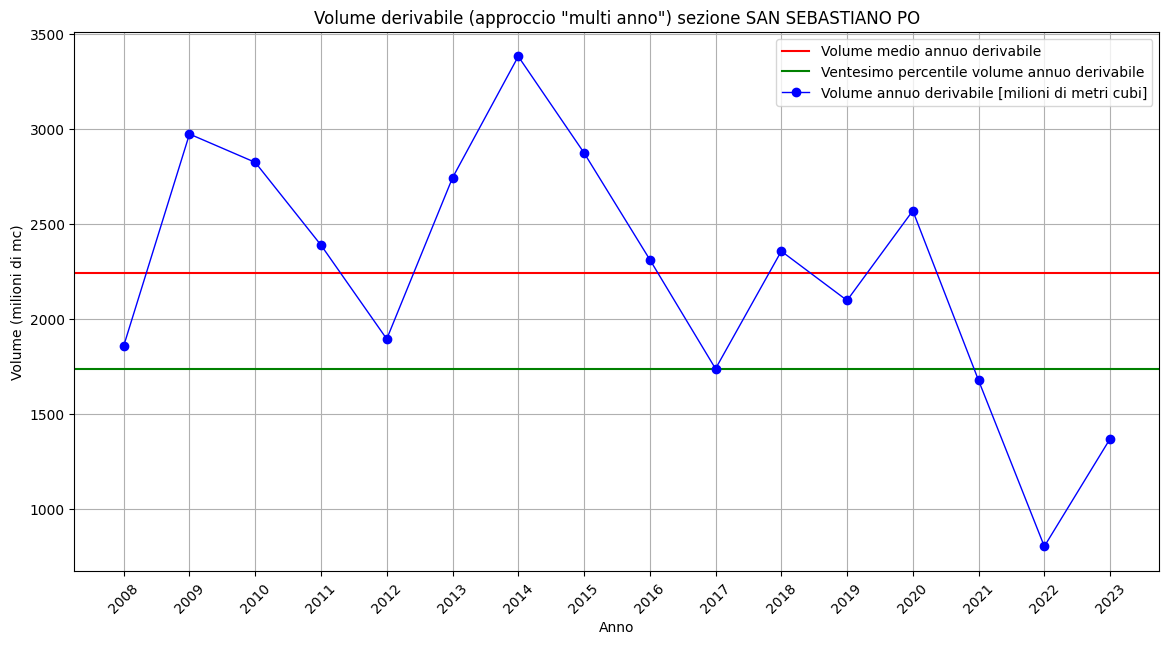

('Il volume medio annuo derivabile ammonta a 2241.0 milioni di metri cubi',
 'Il volume annuo derivabile in un anno scarso (20-esimo percentile) ammonta a 1737.0 milioni di metri cubi')

In [73]:
line_plot_annual_approach(annualVdf_po, "San Sebastiano Po")

#### 4.A.2) BOX PLOT DEI RISULTATI

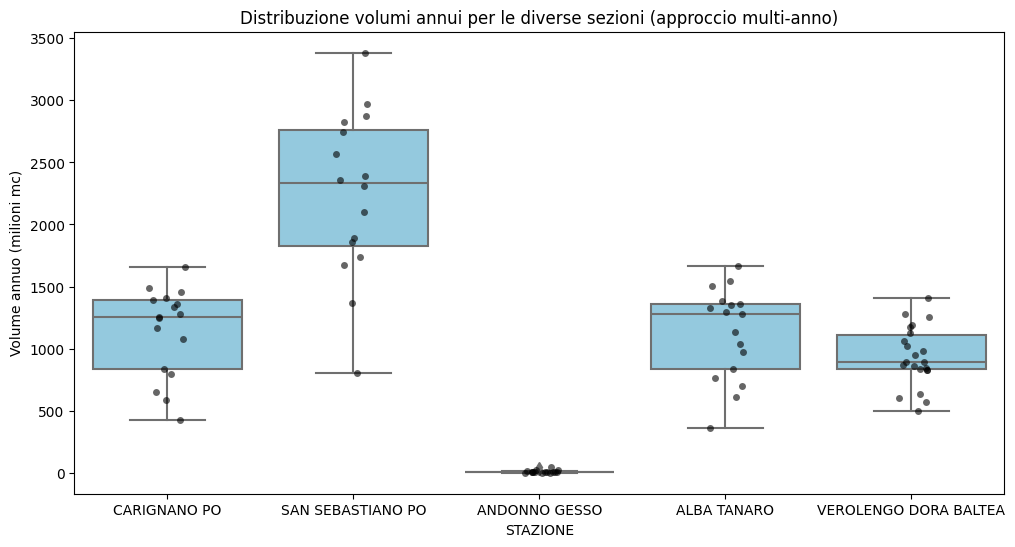

In [74]:
# BOX PLOT VOLUMI ANNUI DERIVABILI

#AGGIUNTA NOME STAZIONE AI df:
annualVdf_carignano["STAZIONE"] = "CARIGNANO PO"
annualVdf_po["STAZIONE"] = "SAN SEBASTIANO PO"
annualVdf_gesso["STAZIONE"] = "ANDONNO GESSO"
annualVdf_tanaro["STAZIONE"] = "ALBA TANARO"
annualVdf_dora["STAZIONE"] = "VEROLENGO DORA BALTEA"

#RAPPRESENTAZIONE IN MILIONI DI METRI CUBI:
annualVdf_carignano["Volume annuo (milioni mc)"] = annualVdf_carignano["Volume annuo (mc)"] / 10**6
annualVdf_po["Volume annuo (milioni mc)"] = annualVdf_po["Volume annuo (mc)"] / 10**6
annualVdf_gesso["Volume annuo (milioni mc)"] = annualVdf_gesso["Volume annuo (mc)"] / 10**6
annualVdf_tanaro["Volume annuo (milioni mc)"] = annualVdf_tanaro["Volume annuo (mc)"] / 10**6
annualVdf_dora["Volume annuo (milioni mc)"] = annualVdf_dora["Volume annuo (mc)"] / 10**6

#MERGE DEI DF:
annualVcombined_df = pd.concat([annualVdf_carignano, annualVdf_po, annualVdf_gesso, annualVdf_tanaro, annualVdf_dora])

#BOX PLOT: 
plt.figure(figsize=(12, 6))
sns.boxplot(data=annualVcombined_df, x="STAZIONE", y="Volume annuo (milioni mc)", color="skyblue")
sns.stripplot(data=annualVcombined_df, x="STAZIONE", y="Volume annuo (milioni mc)", color="black", alpha=0.6, jitter=True)

plt.ylabel("Volume annuo (milioni mc)")
plt.title("Distribuzione volumi annui per le diverse sezioni (approccio multi-anno)")
plt.show()


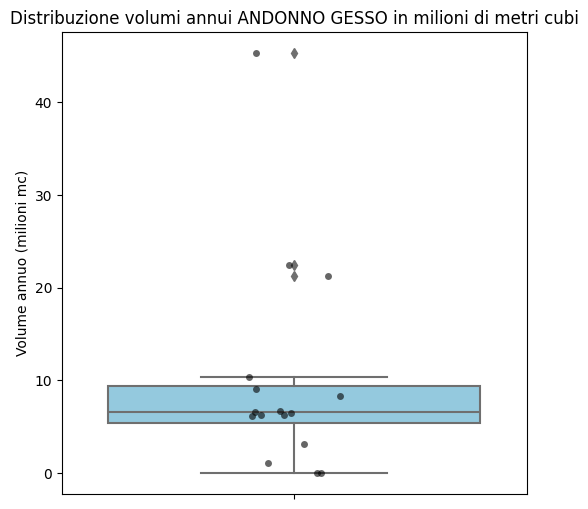

In [75]:
#BOX PLOT GESSO A PARTE
plt.figure(figsize=(6, 6))
sns.boxplot(data=annualVdf_gesso, y="Volume annuo (milioni mc)", color="skyblue")
sns.stripplot(data=annualVdf_gesso, y="Volume annuo (milioni mc)", color="black", alpha=0.6, jitter=True)

plt.ylabel("Volume annuo (milioni mc)")
plt.title("Distribuzione volumi annui ANDONNO GESSO in milioni di metri cubi")
plt.show()


In [76]:
annualVdf_gesso

,Year,Volume annuo (mc),STAZIONE,Volume annuo (milioni mc)
0,2008,4.526972e+07,ANDONNO GESSO,45.269723
1,2009,2.127720e+07,ANDONNO GESSO,21.277196
2,2010,9.021725e+06,ANDONNO GESSO,9.021725
3,2011,8.355090e+06,ANDONNO GESSO,8.355090
4,2012,6.219217e+06,ANDONNO GESSO,6.219217
5,2013,6.502054e+06,ANDONNO GESSO,6.502054
6,2014,6.573784e+06,ANDONNO GESSO,6.573784
7,2015,6.175193e+06,ANDONNO GESSO,6.175193
8,2016,3.103076e+06,ANDONNO GESSO,3.103076
9,2017,0.000000e+00,ANDONNO GESSO,0.000000


### 4.B) APPROCCIO ANNO TIPO

Per ogni dataframe, si vogliono determinare l'anno medio e l'anno scarso, derivati del deflusso ecologico; dopdichè si calcola il volume derivabile per l'anno medio e per l'anno scarso. Conviene creare dei df nuovi contenenti solo le informazioni utili

In [77]:
#poor_mean_year(df_po)

In [78]:
#FUNZIONE CHE CALCOLA ANNO MEDIO E ANNO SCARSO DEPURATI DAL DEFLUSSO ECOLOGICO
def poor_mean_ecologic(df):
    first_year = df["DATA"].iloc[0].year
    last_year = df["DATA"].iloc[-1].year
    df_de = pd.DataFrame()
    df = df.sort_values(by="Portata fiume (m³/s)", ascending=True)
    for year in range(first_year, last_year+1, 1):
        df_de["Q-DE",year] = df.loc[df["DATA"].dt.year == year, "Q-DE"].reset_index(drop=True)
    
    df_de["Q-DE media"] = df_de.mean(axis=1)
    df_de["Q-DE anno scarso"] = df_de.drop(columns=["Q-DE media"]).quantile(0.2, axis=1)
    
    return df, df_de

In [79]:
print(poor_mean_ecologic(df_po))

(           DATA  Portata fiume (m³/s)         DE         Q-DE     Q media  \
1627 2011-08-13                  2.36   4.988221     0.000000  125.234382   
1635 2011-08-21                  2.41   4.988221     0.000000  125.234382   
1640 2011-08-26                  3.11   4.988221     0.000000  125.234382   
1624 2011-08-10                  3.24   4.988221     0.000000  125.234382   
1632 2011-08-18                  3.33   4.988221     0.000000  125.234382   
...         ...                   ...        ...          ...         ...   
4653 2019-11-25               2457.92   4.988221  2452.931779  125.234382   
457  2008-05-30               2474.00  14.252059  2459.747941  125.234382   
1204 2010-06-16               3061.00  14.252059  3046.747941  125.234382   
4652 2019-11-24               3103.34   4.988221  3098.351779  125.234382   
3558 2016-11-25               3879.81   4.988221  3874.821779  125.234382   

      Q derivata  Volume giornaliero derivato (mc)  Year  Month  
1627    

#### 4.B.1) VOLUME DERIVABILE ANNO MEDIO 

In [80]:
# FUNZIONE CHE COMPONE IL DATAFRAME PER L'ANALISI DELL'ANNO MEDIO: si vuole riunire in un unico dataset la Q-DE media, Q disponibile per anno medio e Q derivata per anno medio
def mean_year(df):
    Qmean = np.mean(df["Portata fiume (m³/s)"])
    df, df_de = poor_mean_ecologic(df)
    mean_year_df = pd.DataFrame()
    mean_year_df["Q-DE media"] = df_de["Q-DE media"]
    mean_year_df = mean_year_df.sort_values(by="Q-DE media", ascending=True)
    mean_year_df["d"] = np.arange(365, 0, -1)
    mean_year_df["F sup"] = mean_year_df["d"] / 366
    mean_year_df["Q max derivabile"] = np.full(shape=len(mean_year_df), fill_value=Qmean)
    mean_year_df["Q disponibile"] = [i if i >= 0 else 0 for i in mean_year_df["Q-DE media"]]
    mean_year_df["Q derivata"] = np.minimum(mean_year_df["Q max derivabile"], mean_year_df["Q disponibile"])
    
    
    return mean_year_df, df

In [81]:
# FUNZIONE CHE PLOTTA LA CURVA DI DURATA DELL'ANNO MEDIO E CALCOLA IL VOLUME DERIVABILE (con il metodo trapz), sempre per l'anno MEDIO
def mean_withdrawable_volume(df, station_name):
    mean_year_df, df = mean_year(df)
    plt.figure(figsize=(14, 6))
    Frequenza = mean_year_df["F sup"]
    Qdisponibile = mean_year_df["Q disponibile"]
    Qmax_derivabile = mean_year_df["Q max derivabile"]
    Qderivata = mean_year_df["Q derivata"]

    plt.plot(Frequenza, Qdisponibile, linewidth=1, color="blue", label="CDP portata disponibile alla presa")
    plt.plot(Frequenza, Qmax_derivabile, linewidth=2, color="red", label="Massima Q derivabile dall' opera di presa")

    plt.fill_between(Frequenza, Qderivata, color="lightblue", alpha=1)
    plt.ylim(0, Qdisponibile[364])

    plt.title(f"Volume teorico per l'anno medio STAZIONE {station_name.upper()}") 
    plt.xlabel("Frequenza di superamento")
    plt.ylabel("Portata Q (mc/s)")
    plt.grid(True)
    #plt.yscale("log")
    plt.legend()
    plt.show()
    
    x = np.linspace(0,1, len(Qderivata))
    instant_mvolume = np.trapz(Qderivata, x)
    annual_mvolume = instant_mvolume*60*60*24*365
    annual_mvolume = round(annual_mvolume, 0)
    return f"Il volume derivabile per l'anno medio ammonta a {annual_mvolume:.0f} mc"

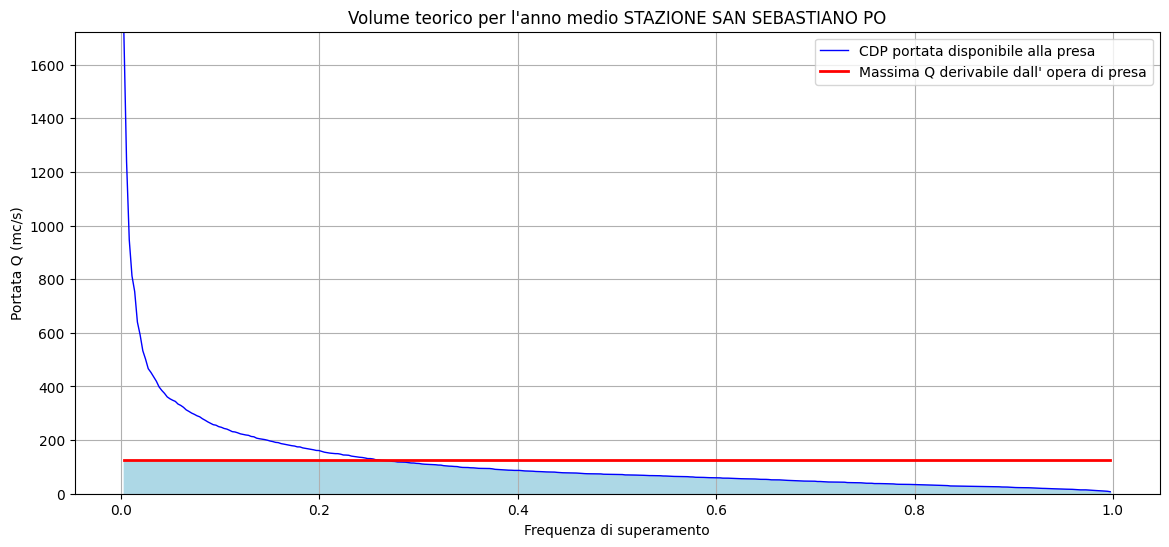

"Il volume derivabile per l'anno medio ammonta a 2378507726 mc"

In [82]:
#ESEMPIO CON df_po
mean_withdrawable_volume(df_po, "San Sebastiano PO")

#### 4.B.2) VOLUME DERIVABILE ANNO SCARSO 

In [83]:
# FUNZIONE CHE COMPONE IL DATAFRAME PER L'ANNO SCARSO: si vuole riunire in un unico dataset la Q scarsa, Q-DE scarsa, Q disponibile per anno scarso e Q derivata per anno scarso
def poor_year(df):
    Qmean = np.mean(df["Portata fiume (m³/s)"])
    df, df_de = poor_mean_ecologic(df)
    poor_year_df = pd.DataFrame()
    poor_year_df["Q-DE anno scarso"] = df_de["Q-DE anno scarso"]
    poor_year_df = poor_year_df.sort_values(by="Q-DE anno scarso", ascending=True)
    poor_year_df["d"] = np.arange(365, 0, -1)
    poor_year_df["F sup"] = poor_year_df["d"] / 366
    poor_year_df["Q max derivabile"] = np.full(shape=len(poor_year_df), fill_value=Qmean)
    poor_year_df["Q disponibile"] = [i if i >= 0 else 0 for i in poor_year_df["Q-DE anno scarso"]]
    poor_year_df["Q derivata"] = np.minimum(poor_year_df["Q max derivabile"], poor_year_df["Q disponibile"])
    
    
    return poor_year_df, df

In [84]:
# FUNZIONE CHE PLOTTA LA CURVA DI DURATA DELL'ANNO SCARSO E CALCOLA IL VOLUME DERIVABILE (con il metodo trapz), sempre per l'anno SCARSO
def poor_withdrawable_volume(df, station_name):
    poor_year_df, df = poor_year(df)
    plt.figure(figsize=(14, 6))
    Frequenza = poor_year_df["F sup"]
    Qdisponibile = poor_year_df["Q disponibile"]
    Qmax_derivabile = poor_year_df["Q max derivabile"]
    Qderivata = poor_year_df["Q derivata"]

    plt.plot(Frequenza, Qdisponibile, linewidth=1, color="blue", label="CDP portata disponibile alla presa")
    plt.plot(Frequenza, Qmax_derivabile, linewidth=2, color="red", label="Massima Q derivabile dall' opera di presa")

    plt.fill_between(Frequenza, Qderivata, color="lightblue", alpha=1)
    plt.ylim(0, Qdisponibile[364])

    plt.title(f"Volume teorico derivabile per l'anno scarso STAZIONE {station_name.upper()}")
    plt.xlabel("Frequenza di superamento")
    plt.ylabel("Portata Q (mc/s)")
    plt.grid(True)
    #plt.yscale("log")
    plt.legend()
    plt.show()
    
    x = np.linspace(0,1, len(Qderivata))
    instant_pvolume = np.trapz(Qderivata, x)
    annual_pvolume = instant_pvolume*60*60*24*365
    annual_pvolume = round(annual_pvolume, 0)
    return f"Il volume derivabile per l'anno scarso ammonta a {annual_pvolume:.0f} mc"

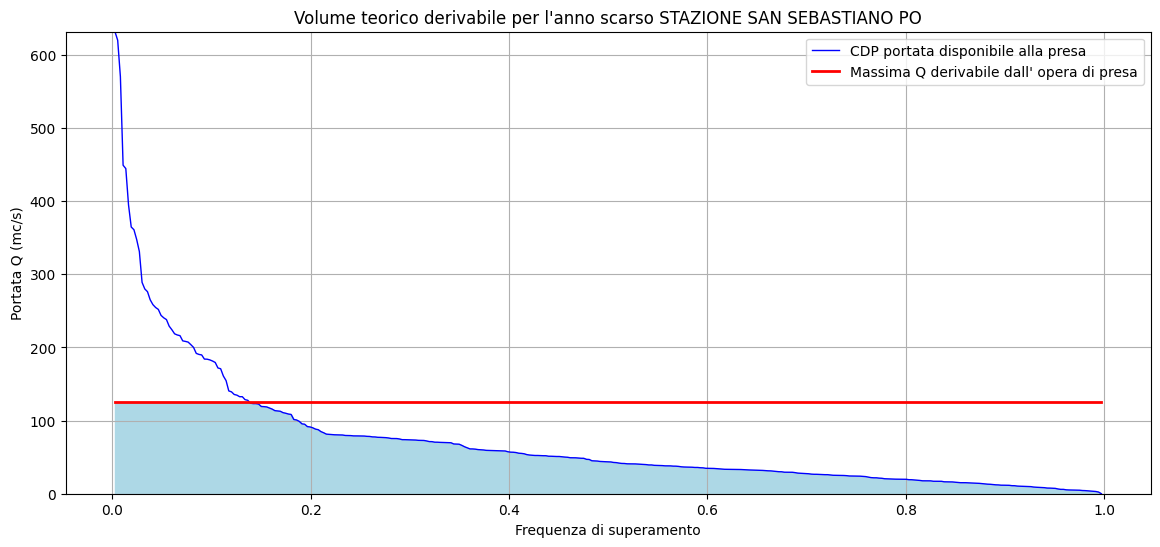

"Il volume derivabile per l'anno scarso ammonta a 1742959604 mc"

In [85]:
#ESEMPIO CON df_po
poor_withdrawable_volume(df_po, "San sebastiano po")

## 5) Discussione dei risultati

### 5.1) Confronto tra i volumi

In [88]:
#FUNZIONE CHE PLOTTA IN UN UNICO GRAFICO: -line plot dei volumi annui da approccio multi-anno (con media e mediana); - linea costante di volume derivabile anno medio e anno scarso di approccio anno tipo

def approaches_comparison(df, df1, df2, station_name):  # df = annualVdf_nome, df1= df_nome, df2 = df_nome
    
    #RAPPRESENTAZIONE A LINEE VOLUME ANNUO DERIVABILE CON APPROCCIO MULTI-ANNO
    plt.figure(figsize=(14,7))
    x = df["Year"]
    y = df["Volume annuo (mc)"]/10**6
    MeanV = y.mean()
    PoorV = np.quantile(y, 0.2)
    
    plt.axhline(y=MeanV, color='r', linestyle='-', label="Volume medio annuo derivabile (multi-anno)") 
    plt.axhline(y=PoorV, color='r', linestyle='-', label="Ventesimo percentile volume annuo derivabile (multi-anno)") 
    
    plt.plot(x, y, linewidth=1, color="blue", label="Volume annuo derivabile [milioni di metri cubi]", marker="o")
    plt.title(f"Confronto tra due i approcci STAZIONE {station_name.upper()}")
    plt.xlabel("Anno")
    plt.ylabel("Volume (milioni di mc)")
    plt.grid(True)
    plt.xticks(ticks=x, rotation=45)
    
    
    #RAPPRESENTAZIONE DEL VOLUME ANNUO con approccio ANNO TIPO - MEDIO
    mean_year_df, df = mean_year(df1)
    Qderivata = mean_year_df["Q derivata"]
    x = np.linspace(0, 1, len(Qderivata))
    instant_mvolume = np.trapz(Qderivata, x)
    annual_mvolume = instant_mvolume * 60 * 60 * 24 * 365
    annual_mvolume = round(annual_mvolume, 0)
    
    plt.axhline(y=annual_mvolume / 10**6, color='limegreen', linestyle='--', label="Volume annuo derivabile (anno-tipo medio)")
    
    #RAPPRESENTAZIONE DEL VOLUME ANNUO con approccio ANNO TIPO - SCARSO
    poor_year_df, df = poor_year(df2)
    Frequenza = poor_year_df["F sup"]
    Qdisponibile = poor_year_df["Q disponibile"]
    Qmax_derivabile = poor_year_df["Q max derivabile"]
    Qderivata = poor_year_df["Q derivata"]
    x = np.linspace(0,1, len(Qderivata))
    instant_pvolume = np.trapz(Qderivata, x)
    annual_pvolume = instant_pvolume*60*60*24*365
    annual_pvolume = round(annual_pvolume, 0)
    
    plt.axhline(y=annual_pvolume / 10**6, color='limegreen', linestyle='--', label="Volume annuo derivabile (anno-tipo scarso)")
    
    
    plt.legend()
    plt.show()
    
    return f"Il volume medio multi-anno differisce dal volume anno-tipo di {round((MeanV - annual_mvolume/10**6), 0)}", f"Il volume scarso multi-anno differisce dal volume scarso anno-tipo di {round((PoorV - annual_pvolume/10**6),0)}"


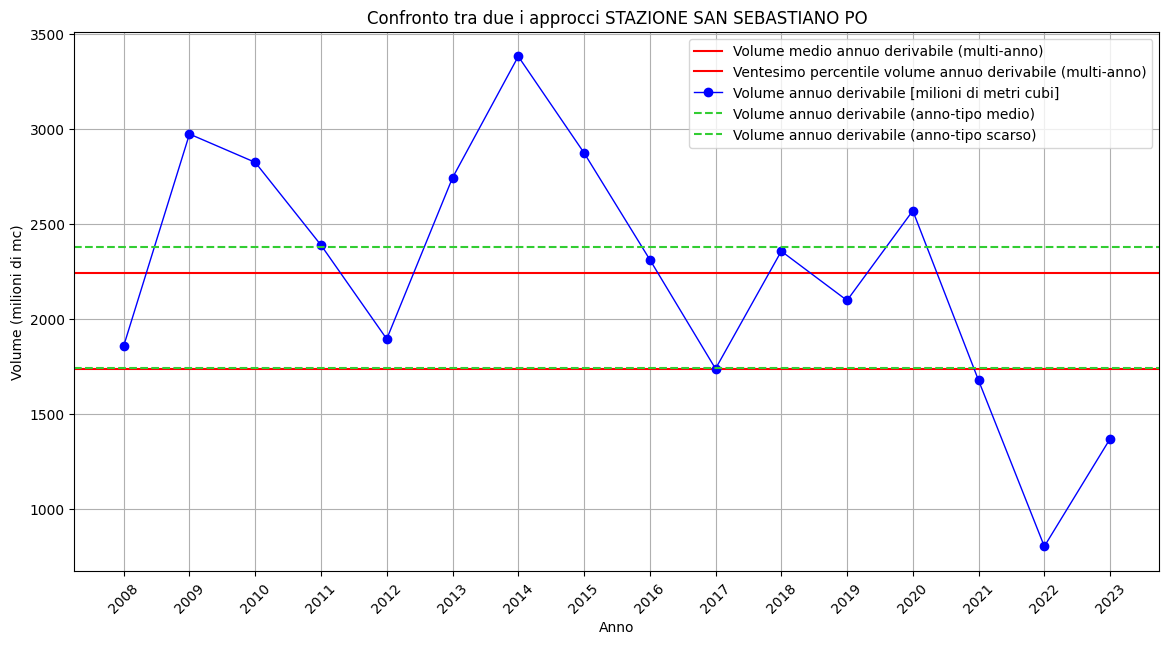

('Il volume medio multi-anno differisce dal volume anno-tipo di -137.0',
 'Il volume scarso multi-anno differisce dal volume scarso anno-tipo di -6.0')

In [94]:
approaches_comparison(annualVdf_po, df_po, df_po, "san sebastiano po")